In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import sys
import pandas as pd

from IPython.display import display
from matplotlib import patches
from PIL import Image

ROOT_DIR = os.path.abspath('../')
sys.path.append(ROOT_DIR)

from module.utils import *

%matplotlib inline

In [3]:
DATA_ROOT = os.path.join(ROOT_DIR, 'data/CONTEC_COMPSAT_K3A_DATASET')
CITY_NAME = ['Daejeon', 'Sejong']
SUB_DIR = os.path.join(DATA_ROOT, '{}_Dataset'.format(CITY_NAME[0]))
# SUB_DIR = os.path.join(DATA_ROOT, 'vehicle_detection_data/daejeon'.format(CITY_NAME[0]))

In [4]:
# Display Dataset Structure
%cd $DATA_ROOT
!tree --dirsfirst --filelimit 10
%cd $ROOT_DIR

/media/ssd1/DATASET/CONTEC_COMPSAT_K3A_DATASET
.
├── Daejeon_Dataset
│   ├── images_test [903 entries exceeds filelimit, not opening dir]
│   ├── images_train [3609 entries exceeds filelimit, not opening dir]
│   ├── test_csv
│   │   ├── athletic_test.csv
│   │   ├── building_test.csv
│   │   └── vehicle_test.csv
│   └── train_csv
│       ├── athletic_train.csv
│       ├── building_train.csv
│       └── vehicle_train.csv
├── Sejong_Dataset
│   ├── images_test [406 entries exceeds filelimit, not opening dir]
│   ├── images_train [1620 entries exceeds filelimit, not opening dir]
│   ├── test_csv
│   │   ├── athletic_test.csv
│   │   ├── building_test.csv
│   │   └── vehicle_test.csv
│   └── train_csv
│       ├── athletic_train.csv
│       ├── building_train.csv
│       └── vehicle_train.csv
└── vehicle_detection_data
    └── daejeon
        ├── test [903 entries exceeds filelimit, not opening dir]
        ├── test_csv
        │   ├── athletic_test_new.csv
        │   ├── building_test_ne

In [5]:
def SeparateToRegions2(gt_bbox, rois, th=0.5):
    regions = np.array([], dtype=np.float32).reshape(0, 5)
    deltas = np.array([], dtype=np.float32).reshape(0, 4)

    pos_candidate = np.array([], dtype=np.float32).reshape(0, 5)
    rois_copy = rois.copy()

    for gt in gt_bbox:
        sub_regions = np.array([], dtype=np.float32).reshape(0, 5)

        iou = ComputeIOU(gt, rois_copy)

        # ADD Candidate Positive Regions(IOU > 0.5)
        idx = np.where(iou > th)[0]
        sub_regions = np.vstack([sub_regions, np.column_stack([rois_copy[idx], iou[idx]])])
        rois_copy = np.delete(rois_copy, idx, axis=0)

        # ADD GT
        gt = np.insert(gt, 4, 1.0)
        sub_regions = np.vstack([sub_regions, gt])
        sub_delta = ComputeTargetDelta(gt, sub_regions)

        deltas = np.vstack([deltas, np.delete(sub_delta, 4, axis=1)])
        pos_candidate = np.vstack([pos_candidate, sub_regions])

    # Positive Regions Sort(Descending)

    sort_dix = np.argsort(-pos_candidate[:, 4])
    pos_candidate = pos_candidate[sort_dix][:32]
    pos_candidate = np.delete(pos_candidate, 4, axis=1)
    deltas = deltas[:32]

    # ADD Positive Regions
    regions = np.vstack([regions, np.insert(pos_candidate[:], 4, 1, axis=1)])

    # ADD Negative Regions
    if rois_copy.shape[0] > 96:
        neg_idx = random.sample(range(rois_copy.shape[0]), 96)
        rois_copy = rois_copy[neg_idx]
    regions = np.vstack([regions, np.insert(rois_copy[:], 4, 0, axis=1)])

    return regions, deltas

In [6]:
def RegionProposal(img, img_file, gt_bbox, is_visible=False):
    # 1. Extract Candidate Region of Interest Using Selective Search
    rois = SelectiveSearch(img)
    
    # 2. Separate to Pos/Neg Region
    regions, deltas = SeparateToRegions2(gt_bbox, rois, th=0.7)

    if is_visible:
        fig, ax = plt.subplots(2, 2, figsize=(10, 10))
        DrawBoxes(img, gt_bbox, title='Ground Truth', ax=ax[0][0])
        DrawBoxes(img, rois, title='Candidate ROI', color='r', ax=ax[0][1])
        DrawBoxes(img, regions[np.where(regions[:,4] == 1)], title='Pos Regions', color='b', linestyle="-", ax=ax[1][0])
        DrawBoxes(img, regions[np.where(regions[:,4] == 0)], title='Neg Regions', color='c', linestyle="-", ax=ax[1][1])
        plt.tight_layout()
    
    return regions, deltas

In [7]:
def Visualize(img_dir, img_file, ann_data):
#     print('image_file::', img_file)
    img_path = os.path.join(img_dir, img_file)
    img = cv2.imread(img_path)
    gt_bbox = ann_data[np.where(ann_data[:, 0]==img_file)][:,1:]
    
    return img,gt_bbox
    

In [8]:
def DrawBoxes(img, bboxes, title='', color='magenta', linestyle="solid", ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(10, 10))

    # BBox Display
    # Box 좌표 구성(xmin, ymin, xmax, ymax)
    for bbox in bboxes:
        p = patches.Rectangle((bbox[0], bbox[1]), (bbox[2] - bbox[0]), (bbox[3] - bbox[1]), linewidth=2, alpha=1.0, linestyle=linestyle, edgecolor=color, facecolor='none')
        ax.add_patch(p)

    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.axis('off')
    ax.set_title(title)

### Building Category Visualization

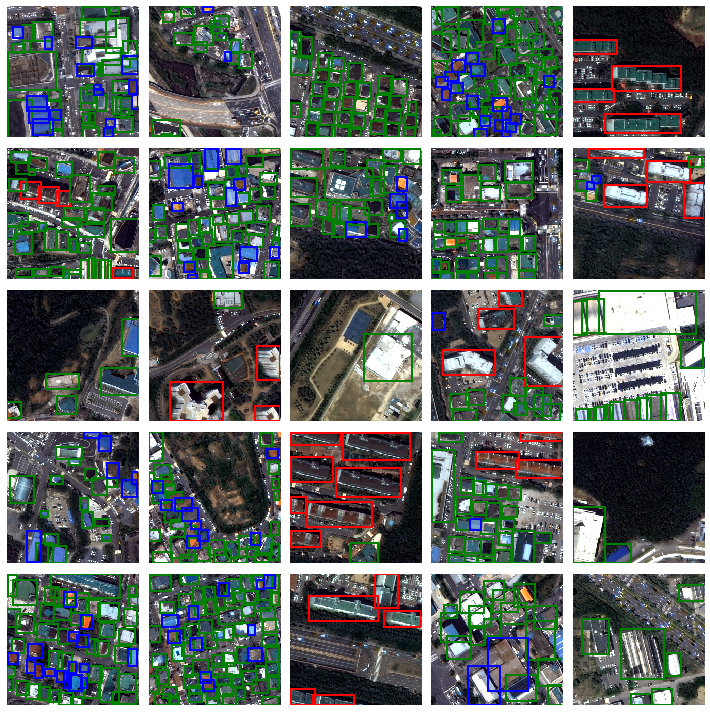

In [9]:
DATA_ROOT = os.path.join(ROOT_DIR, 'data/CONTEC_COMPSAT_K3A_DATASET')
CITY_NAME = ['Daejeon', 'Sejong']
SUB_DIR = os.path.join(DATA_ROOT, '{}_Dataset'.format(CITY_NAME[0]))
# Annotation Read
ANN_DIR = os.path.join(SUB_DIR, 'train_csv')
ann_file = 'building_train.csv'
ann_path = os.path.join(ANN_DIR, ann_file)

ann_data = pd.read_csv(ann_path)
ann_data = ann_data[['filename', 'class', 'xmin', 'ymin', 'xmax', 'ymax']]
ann_data = np.array(ann_data)

# print(np.sort(a)[:])

# Image Load
IMG_DIR = os.path.join(SUB_DIR, 'images_train')
img_list = np.unique(ann_data[:,0]).tolist()
# img_file = random.choice(img_list)
# img_file = 'K3A_20180707043623_18123_00027139_L1R_tile_24080_24060_63_94_78_93.png'

img_files = random.sample(img_list, 25)

fig, ax = plt.subplots(5, 5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        img_file = img_files[i * 5 + j]
        img, gt_bbox = Visualize(IMG_DIR, img_file, ann_data)

        DrawBoxes(img, 
                  gt_bbox[np.where(gt_bbox[:,0] == 'APR')[0]][:,1:], 
                  color='r', ax=ax[i][j])
        DrawBoxes(img, 
                  gt_bbox[np.where(gt_bbox[:,0] == 'OB')[0]][:,1:], color='g', 
                  ax=ax[i][j])
        DrawBoxes(img, 
                  gt_bbox[np.where(gt_bbox[:,0] == 'VI')[0]][:,1:], color='b', 
                  ax=ax[i][j])
plt.tight_layout()

# print('gt_bbox ::\n', gt_bbox)
# regions, _ = RegionProposal(img, img_file, gt_bbox, is_visible=True)
# print(regions.shape)

[['APR' 48 31 193 86]
 ['APR' 201 61 256 101]
 ['APR' 15 185 165 245]
 ['APR' 163 218 256 256]
 ['OB' 8 103 79 170]]


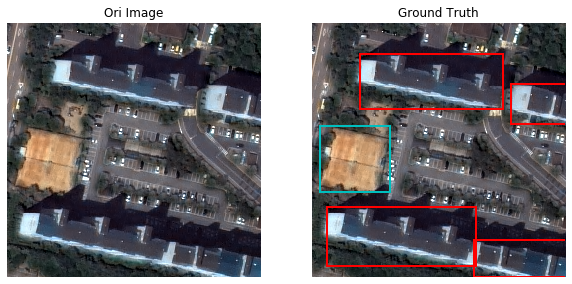

In [10]:

img_file = 'K3A_20180707043623_18123_00027139_L1R_tile_24080_24060_66_94_2_93.png'
gt_bbox = ann_data[np.where(ann_data[:, 0]==img_file)][:,1:]
img = cv2.imread(os.path.join(IMG_DIR, img_file))
print(gt_bbox)
fig, ax = plt.subplots(1,2, figsize=(10, 10))
# fig.suptitle('Annotation Sample\n({})'.format(img_file))
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[0].axis('off')
ax[0].set_title('Ori Image')
DrawBoxes(img, gt_bbox[np.where(gt_bbox[:,0] == 'APR')[0]][:,1:], color='r', title='Ground Truth', ax=ax[1])
DrawBoxes(img, gt_bbox[np.where(gt_bbox[:,0] == 'OB')[0]][:,1:], color='c', title='Ground Truth', ax=ax[1])
DrawBoxes(img, gt_bbox[np.where(gt_bbox[:,0] == 'VI')[0]][:,1:], color='b', title='Ground Truth', ax=ax[1])
# plt.tight_layout()

In [11]:
filenames = ['K3A_20180707043623_18123_00027139_L1R_tile_24080_24060_66_94_2_93.png' for i in range(5)]
confidence = [0.84, 0.97, 0.88, 0.75, 0.91]
classes = ['APT', 'APT', 'OB', 'OB', 'VI']
xmin = [48, 201, 15, 163, 8]
ymin = [31, 61, 185, 218, 79]
xmax = [193, 256, 165, 256, 170]
ymax = [86, 101, 245, 256, 170]

dataframe = pd.DataFrame({'filename' : filenames,
                          'class' : classes,
                          'confidence':confidence,
                          'xmin' : xmin, 
                          'ymin' : ymin,
                          'xmax' : xmax,
                          'ymax' : ymax})
# dataframe.to_csv("{}/{}_{}.csv".format(JOB_DIR, job_name, filestr), header=True, index=False)
dataframe

,filename,class,confidence,xmin,ymin,xmax,ymax
0,K3A_20180707043623_18123_00027139_L1R_tile_240...,APT,0.84,48,31,193,86
1,K3A_20180707043623_18123_00027139_L1R_tile_240...,APT,0.97,201,61,256,101
2,K3A_20180707043623_18123_00027139_L1R_tile_240...,OB,0.88,15,185,165,245
3,K3A_20180707043623_18123_00027139_L1R_tile_240...,OB,0.75,163,218,256,256
4,K3A_20180707043623_18123_00027139_L1R_tile_240...,VI,0.91,8,79,170,170


Using TensorFlow backend.


(1, 55, 145, 3)


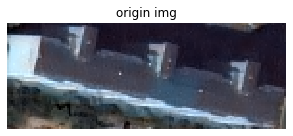

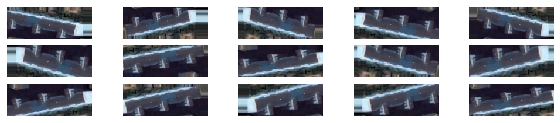

In [12]:
from keras.preprocessing.image import ImageDataGenerator

region_img = img[int(ymin[0]):int(ymax[0]), int(xmin[0]):int(xmax[0])]
region_img = cv2.cvtColor(region_img, cv2.COLOR_BGR2RGB)
x = np.expand_dims(region_img, axis=0)
print(x.shape)
np.random.seed(10)
train_datagen = ImageDataGenerator(width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   zoom_range=[0.8, 1.2],
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

batch_list = np.array([], dtype=np.uint8).reshape(0, 55, 145, 3)
for i, batch in enumerate(train_datagen.flow(x, batch_size=1)):
    batch_list = np.vstack([batch_list, (batch).astype(np.uint8)])
    
    i += 1
    if i > 25:
        break

# dimension 축소
# batch = np.squeeze(batch, axis=0)
fig = plt.figure(figsize=(5, 5))
plt.imshow(region_img)
plt.axis('off')
plt.title('origin img')
# plt.tight_layout()

fig, ax = plt.subplots(3, 5, figsize=(10, 2))
# fig.suptitle('Data Augmentation Image', fontsize=16)
for i in range(3):
    for j in range(5):
        ax[i][j].imshow(batch_list[i * 5  + j])
        ax[i][j].axis('off')

### Vehicle Category Visualization

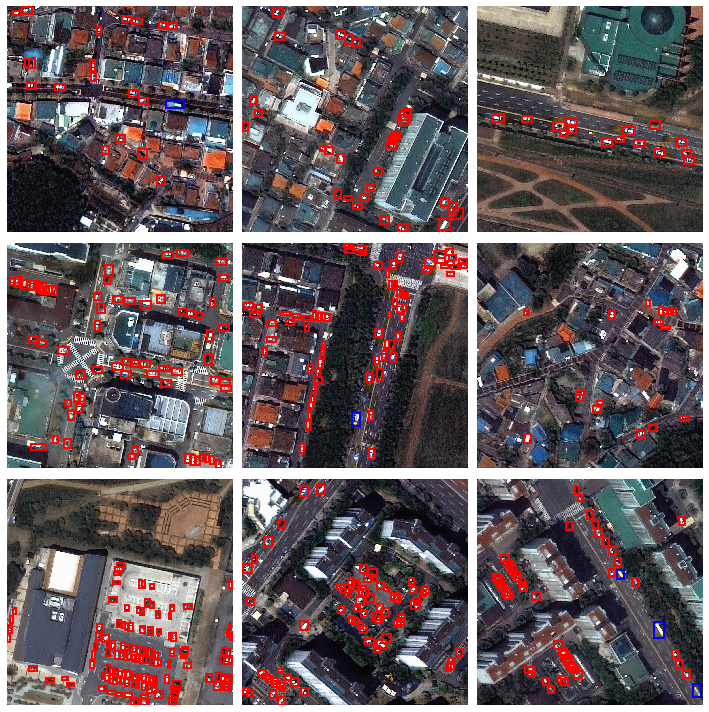

In [13]:
DATA_ROOT = os.path.join(ROOT_DIR, 'data/CONTEC_COMPSAT_K3A_DATASET')
CITY_NAME = ['Daejeon', 'Sejong']
SUB_DIR = os.path.join(DATA_ROOT, 'vehicle_detection_data/daejeon'.format(CITY_NAME[0]))

# Annotation Read
ANN_DIR = os.path.join(SUB_DIR, 'train_csv')
ann_file = 'vehicle_train_new.csv'
ann_path = os.path.join(ANN_DIR, ann_file)

ann_data = pd.read_csv(ann_path)
ann_data = ann_data[['filename', 'class', 'xmin', 'ymin', 'xmax', 'ymax']]
ann_data = np.array(ann_data)
# display(pd.DataFrame(ann_data))

# Image Load
IMG_DIR = os.path.join(SUB_DIR, 'train')
img_list = np.unique(ann_data[:,0]).tolist()

img_files = random.sample(img_list, 25)
# print('\n'.join(img_files))
fig, ax = plt.subplots(3, 3, figsize=(10, 10))

for i in range(3):
    for j in range(3):
        img_file = img_files[i * 5 + j]
        img, gt_bbox = Visualize(IMG_DIR, img_file, ann_data)
        DrawBoxes(img, 
                  gt_bbox[np.where(gt_bbox[:,0] == 'SV')[0]][:,1:], 
                  color='r', ax=ax[i][j])
        DrawBoxes(img, 
                  gt_bbox[np.where(gt_bbox[:,0] == 'LV')[0]][:,1:], color='b', 
                  ax=ax[i][j])
plt.tight_layout()

[['LV' 816 340 856 436]
 ['LV' 564 652 644 692]
 ['LV' 656 744 740 776]
 ['LV' 748 760 828 796]
 ['LV' 944 800 1020 840]
 ['LV' 432 620 532 664]
 ['LV' 352 604 416 632]
 ['LV' 212 312 252 388]
 ['LV' 296 192 324 244]
 ['LV' 852 4 888 68]
 ['LV' 192 428 216 488]
 ['SV' 336 0 364 24]
 ['SV' 328 72 344 116]
 ['LV' 288 256 308 320]
 ['SV' 232 264 252 300]
 ['SV' 180 508 196 548]
 ['SV' 236 524 244 552]
 ['LV' 736 596 760 656]
 ['SV' 880 788 920 808]]


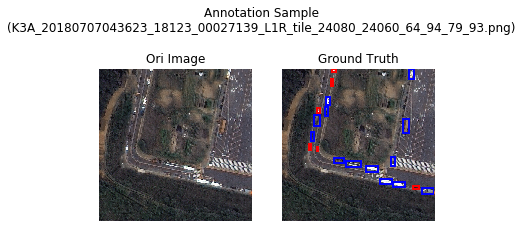

In [14]:
img_file = 'K3A_20180707043623_18123_00027139_L1R_tile_24080_24060_48_94_2_93.png'
gt_bbox = ann_data[np.where(ann_data[:, 0]==img_file)][:,1:]
img = cv2.imread(os.path.join(IMG_DIR, img_file))
print(gt_bbox)

fig, ax = plt.subplots(1,2)
fig.suptitle('Annotation Sample\n({})'.format(img_files[0]))
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[0].axis('off')
ax[0].set_title('Ori Image')
DrawBoxes(img, gt_bbox[np.where(gt_bbox[:,0] == 'SV')[0]][:,1:], color='r', title='Ground Truth', ax=ax[1])
DrawBoxes(img, gt_bbox[np.where(gt_bbox[:,0] == 'LV')[0]][:,1:], color='b', title='Ground Truth', ax=ax[1])
# plt.tight_layout()

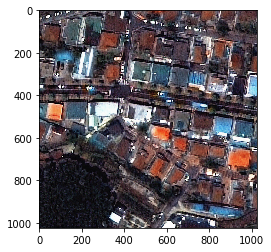

In [168]:
img_file = 'K3A_20180707043623_18123_00027139_L1R_tile_24080_24060_64_94_79_93.png'
img = cv2.imread(os.path.join(IMG_DIR, img_file))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [171]:
# img_c = img /255.
new_img = img.copy().astype(np.float32)
new_img2 = img.copy().astype(np.float32)
new_img3 = img.copy().astype(np.float32)

mean = np.array([]).reshape(0)
for i in range(new_img.shape[2]):
    mean = np.mean(new_img[:,:,i])
    std = np.std(new_img[:,:,i])
    new_img2[:,:,i] = new_img[:,:,i] - mean
    new_img3[:,:,i] = (new_img[:,:,i] - mean) / std
    
R = new_img[:,:,0]
G = new_img[:,:,1]
B = new_img[:,:,2]

R2 = new_img2[:,:,0]
G2 = new_img2[:,:,1]
B2 = new_img2[:,:,2]

R3 = new_img3[:,:,0]
G3 = new_img3[:,:,1]
B3 = new_img3[:,:,2]

(-10, 10)

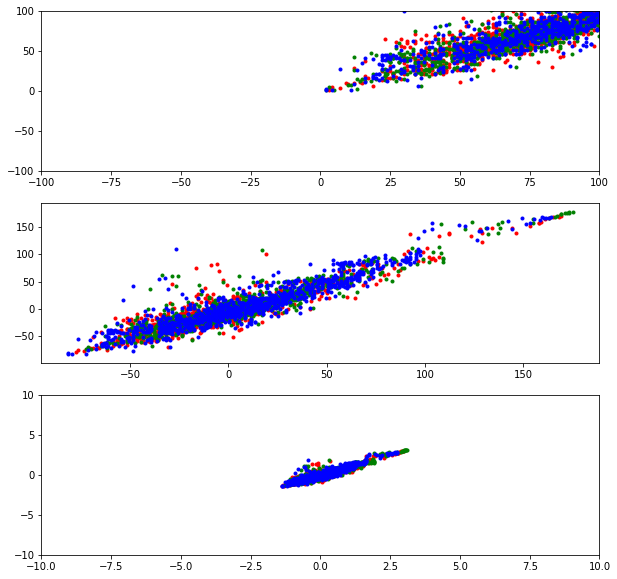

In [180]:
fig, ax = plt.subplots(3,1, figsize=(10,10))

# ax[0] = plt.gca()
# ax[0].spines['right'].set_color('none')
# ax[0].spines['top'].set_color('none')
# ax[0].xaxis.set_ticks_position('bottom')
# ax[0].spines['bottom'].set_position(('data',0))
# ax[0].yaxis.set_ticks_position('left')
# ax[0].spines['left'].set_position(('data',0))

ax[0].scatter(R[0],R[1], color='r', marker='.')
ax[0].scatter(G[0],G[1], color='g', marker='.')
ax[0].scatter(B[0],B[1], color='b', marker='.')
ax[0].set_xlim(-255,255)
ax[0].set_ylim(-255,255)

ax[1].scatter(R2[0],R2[1], color='r', marker='.')
ax[1].scatter(G2[0],G2[1], color='g', marker='.')
ax[1].scatter(B2[0],B2[1], color='b', marker='.')
ax[0].set_xlim(-100,100)
ax[0].set_ylim(-100,100)

ax[2].scatter(R3[0],R3[1], color='r', marker='.')
ax[2].scatter(G3[0],G3[1], color='g', marker='.')
ax[2].scatter(B3[0],B3[1], color='b', marker='.')
ax[2].set_xlim(-10,10)
ax[2].set_ylim(-10,10)


